In [1]:
import sys,copy,re,importlib,pathlib,json,multiprocessing,os,time,inspect
import pandas as pd
import numpy as np
import tensorflow as tf
import math, scipy, sys
from IPython.display import display
from functools import reduce
import pathlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly
#import plotly.express as px
import sklearn.ensemble, sklearn.metrics, sklearn.feature_selection, sklearn.preprocessing, sklearn.decomposition
import sklearn.model_selection, sklearn.utils, sklearn.linear_model, sklearn.pipeline, sklearn.manifold
import sklearn.naive_bayes,sklearn.discriminant_analysis,sklearn.base,sklearn.compose,sklearn.neural_network
import dython,pickle
from apps.attritionml import mlmodeldefinition
importlib.reload(mlmodeldefinition)
pd.set_option('display.max_columns', 5000)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
testInputDfFile = (pathlib.Path() /  'attritionproject.csv').resolve()
srcdf = pd.read_csv(testInputDfFile)

## 資料預處理

### 檢查遺漏值，區別變數型態

In [3]:
continueousVars = []
categoricalVars = []
for col in srcdf.columns:
  missingvaluesNA = pd.isna(srcdf[col])
  missingvaluesNull = pd.isnull(srcdf[col])
  if sum(missingvaluesNA)>0 or sum(missingvaluesNull)>0:
    print(f'number of missing value at column {col} > 0')
  if col=='Attrition':
    pass
  elif srcdf[col].dtype in ['object','category']:
    categoricalVars.append(col)
    print('column {} has {} levels'.format(col, len(srcdf[col].unique()) ))
  else:
    continueousVars.append(col)
display('continueousVars are {}'.format(continueousVars))

column BusinessTravel has 3 levels
column Department has 3 levels
column EducationField has 6 levels
column Gender has 2 levels
column JobRole has 9 levels
column MaritalStatus has 3 levels
column Over18 has 1 levels
column OverTime has 2 levels


"continueousVars are ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']"

In [4]:
display(srcdf, srcdf[continueousVars].describe(), srcdf[categoricalVars].describe())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470
unique,3,3,6,2,9,3,1,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1043,961,606,882,326,673,1470,1054


### 檢查資料有沒有分布過偏、需要整併的情形 順便觀察到應變數分布情形（發現資料不平衡）

In [5]:
srcdf = pd.read_csv(testInputDfFile)
srcdfY = srcdf.loc[:,'Attrition']
lbzedSrcdfY = sklearn.preprocessing.LabelBinarizer().fit(srcdfY)
lbzedSrcdfY = lbzedSrcdfY.transform(srcdfY)[:,0]
pd.DataFrame(data={'srcdfY':srcdfY, 'lbzedSrcdfY':lbzedSrcdfY})

,srcdfY,lbzedSrcdfY
0,Yes,1
1,No,0
2,Yes,1
3,No,0
4,No,0
...,...,...
1465,No,0
1466,No,0
1467,No,0
1468,No,0


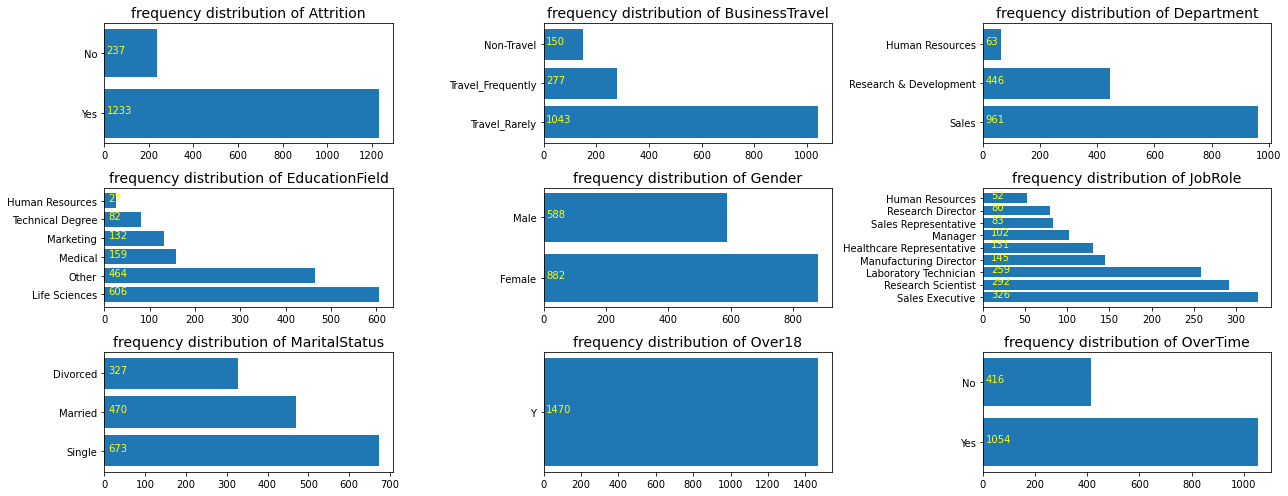

In [6]:
def plotVarsDist(srcd=srcdf, subplots=True, nSubplotCols=3, vartype='conti', displayVars=None, chartType='hist', figsize=(18, 10), titlefontsize=14):
    categoricalVars = [col for col in srcd if srcd[col].dtype in ['object','category']] if displayVars is None else displayVars
    continueousVars = [col for col in srcd if srcd[col].dtype not in ['object','category']] if displayVars is None else displayVars
    if displayVars==None:
        listvars = categoricalVars if vartype=='catg' else continueousVars
    else:
        listvars = displayVars
    if subplots:
        fig, ax = plt.subplots(math.ceil(len(listvars)/nSubplotCols), nSubplotCols, figsize=figsize)
        rowi = -1
        for i,col in enumerate(listvars):
            if i%nSubplotCols==0:
                rowi += 1
            if vartype=='catg':
                ax[rowi][i%nSubplotCols].barh(srcd[col].unique(),srcd[col].value_counts())
                ax[rowi][i%nSubplotCols].set_title(f"frequency distribution of {col}", fontsize=titlefontsize)
                for labeltexti, labeltext in enumerate(srcd[col].value_counts()):
                    ax[rowi][i%nSubplotCols].text(10, labeltexti, labeltext, color='yellow')
            else:
                if chartType in ['boxplot','box']:
                    q25, q75 = srcdf[col].quantile(0.25), srcdf[col].quantile(0.75)
                    iqr = q75-q25
                    outliers = srcdf[col][ (srcdf[col]<q25-1.5*iqr) | (srcdf[col]>q75+1.5*iqr) ]
                    n_outliers = outliers.size
                    ax[rowi][i%nSubplotCols].boxplot(srcdf[col])
                    try:
                        ax[rowi][i%nSubplotCols].text(1.15, max(srcdf[col]), '{} percent outliers'.format( np.round(n_outliers/srcdf[col].size,4) ), color='red')
                    except Exception as e:
                        print(f'error at col {col} for {e}')
                        #raise(e)
                else:
                    ax[rowi][i%nSubplotCols].hist(srcdf[col],bins=50)
                ax[rowi][i%nSubplotCols].set_title(f"distribution of {col}", fontsize=titlefontsize)
        plt.tight_layout()
        plt.show()
    else:
        for i,col in enumerate(listvars):
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            if vartype=='catg':
                ax.barh(srcd[col].unique(),srcd[col].value_counts())
            else:
                ax.hist(srcdf[col],bins=50)
            ax.set_title(f"distribution of {col}", fontsize=titlefontsize)
            plt.show()
plotVarsDist(srcdf,vartype='catg',figsize=(18,7))
srcdf = srcdf.drop(columns=['Attrition'])

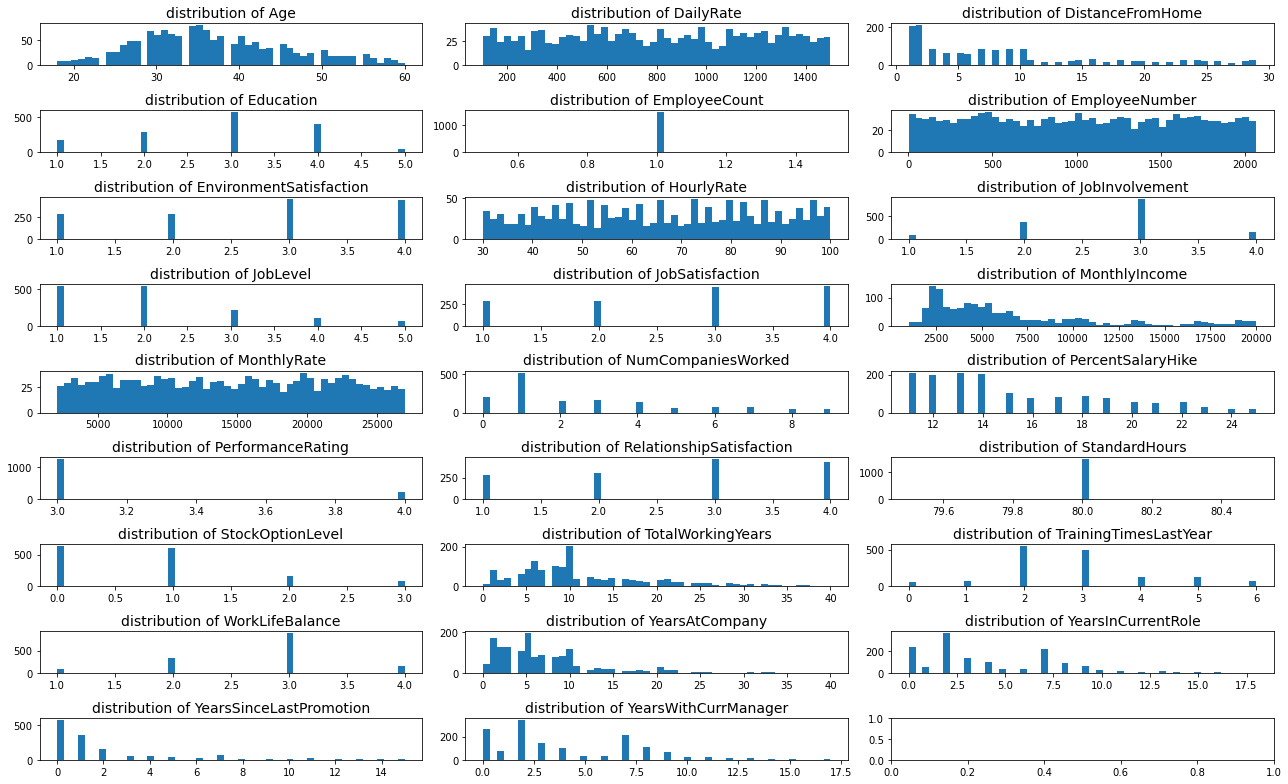

In [7]:
plotVarsDist(srcdf,vartype='conti',figsize=(18,11))

### 發現異常沒有變異的變數，再次檢查後刪掉；處理次序資料（某些變項應該是次序變項，重新指定）

array(['Y'], dtype=object)

array([1], dtype=int64)

array([80], dtype=int64)

,BusinessTravel1,BusinessTravel2,Education1,Education2,Education3,Education4,EnvironmentSatisfaction1,EnvironmentSatisfaction2,EnvironmentSatisfaction3,JobInvolvement1,JobInvolvement2,JobInvolvement3,JobLevel1,JobLevel2,JobLevel3,JobLevel4,JobSatisfaction1,JobSatisfaction2,JobSatisfaction3,PerformanceRating1,PerformanceRating2,PerformanceRating3,RelationshipSatisfaction1,RelationshipSatisfaction2,RelationshipSatisfaction3,StockOptionLevel1,StockOptionLevel2,StockOptionLevel3,WorkLifeBalance1,WorkLifeBalance2,WorkLifeBalance3,Age,DailyRate,Department,DistanceFromHome,EducationField,EmployeeNumber,Gender,HourlyRate,JobRole,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,1102,Sales,1,Life Sciences,1,Female,94,Sales Executive,Single,5993,19479,8,Yes,11,8,0,6,4,0,5
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,49,279,Research & Development,8,Life Sciences,2,Male,61,Research Scientist,Married,5130,24907,1,No,23,10,3,10,7,1,7
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,37,1373,Research & Development,2,Other,4,Male,92,Laboratory Technician,Single,2090,2396,6,Yes,15,7,3,0,0,0,0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,33,1392,Research & Development,3,Life Sciences,5,Female,56,Research Scientist,Married,2909,23159,1,Yes,11,8,3,8,7,3,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,27,591,Research & Development,2,Medical,7,Male,40,Laboratory Technician,Married,3468,16632,9,No,12,6,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,36,884,Research & Development,23,Medical,2061,Male,41,Laboratory Technician,Married,2571,12290,4,No,17,17,3,5,2,0,3
1466,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,39,613,Research & Development,6,Medical,2062,Male,42,Healthcare Representative,Married,9991,21457,4,No,15,9,5,7,7,1,7
1467,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,27,155,Research & Development,4,Life Sciences,2064,Male,87,Manufacturing Director,Married,6142,5174,1,Yes,20,6,0,6,2,0,3
1468,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,49,1023,Sales,2,Medical,2065,Male,63,Sales Executive,Married,5390,13243,2,No,14,17,3,9,6,0,8


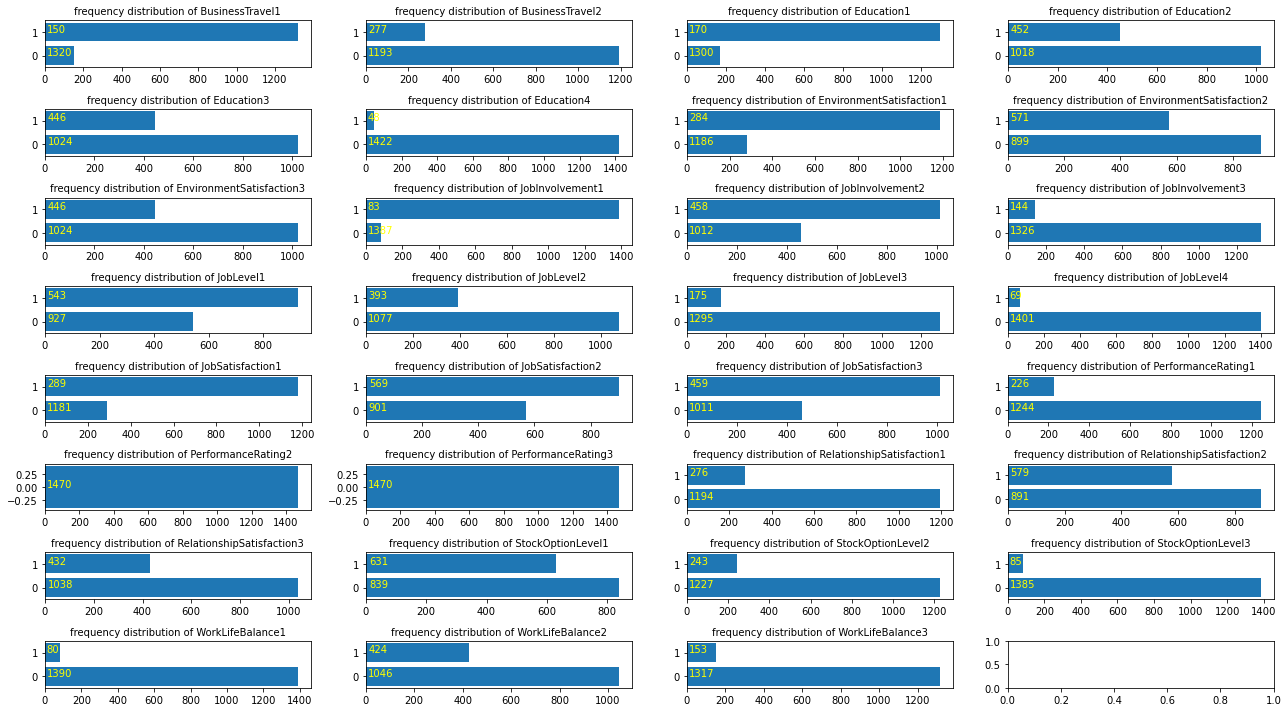

In [8]:
#沒有變異的變數
checkvars = ['Over18','EmployeeCount','StandardHours']
for checkvar in checkvars:
    display(srcdf[checkvar].unique())
cleanedsrcdf = {'0dropped':srcdf.drop(columns=checkvars)}
try:
    continueousVars.remove('EmployeeCount')
    continueousVars.remove('StandardHours')
    categoricalVars.remove('Over18')
    categoricalVars.remove('BusinessTravel')
except:
    pass

#次序資料
#重新編碼BusinessTravel欄位
cleanedsrcdf['0dropped'] = cleanedsrcdf['0dropped'].replace({'Non-Travel':0,'Travel_Rarely':1,'Travel_Frequently':2})
ordinalVarsLevels = {'BusinessTravel':3,'Education':5,'EnvironmentSatisfaction':4,'JobInvolvement':4,'JobLevel':5,'JobSatisfaction':4,'PerformanceRating':4,'RelationshipSatisfaction':4,'StockOptionLevel':4,'WorkLifeBalance':4}
#ordinalVarsLevels = {'BusinessTravel':3,'Education':5,'EnvironmentSatisfaction':4}
ordinalVars = list(ordinalVarsLevels.keys())
realContiVars = [col for col in continueousVars if col not in ordinalVars]

cleanedsrcdf['0dropped1ordinaled'] = cleanedsrcdf['0dropped'].loc[:,:]
cleanedsrcdf['0dropped1ordinaled'].loc[:,ordinalVars] = cleanedsrcdf['0dropped1ordinaled'].loc[:,ordinalVars]-cleanedsrcdf['0dropped1ordinaled'].loc[:,ordinalVars].min()
ordinalColumnTransformers = []
for col,levels in ordinalVarsLevels.items():
    #累積機率的encoding
    cumulativeOrdinalTransformer = (col+'Condor',mlmodeldefinition.CustomCondorOrdinalEncoder(nclasses=levels),col)
    ordinalColumnTransformers.append(cumulativeOrdinalTransformer)
coltransformer = sklearn.compose.ColumnTransformer(ordinalColumnTransformers, remainder='passthrough', verbose_feature_names_out=False).fit(cleanedsrcdf['0dropped1ordinaled'])
cleanedsrcdf['0dropped1ordinaled'] = pd.DataFrame(data=coltransformer.transform(cleanedsrcdf['0dropped1ordinaled']),columns=coltransformer.get_feature_names_out())
display(cleanedsrcdf['0dropped1ordinaled'])
convertedOrdinalVars = [col for col in coltransformer.get_feature_names_out() if col not in realContiVars+categoricalVars]
#cleanedsrcdf['0dropped1ordinaled'].loc[:,convertedOrdinalVars] = cleanedsrcdf['0dropped1ordinaled'].loc[:,convertedOrdinalVars].astype('category')
plotVarsDist(cleanedsrcdf['0dropped1ordinaled'].loc[:,convertedOrdinalVars].astype('category'),vartype='catg', nSubplotCols=4, figsize=(18,10), titlefontsize=10)

### 檢查是否有離群值

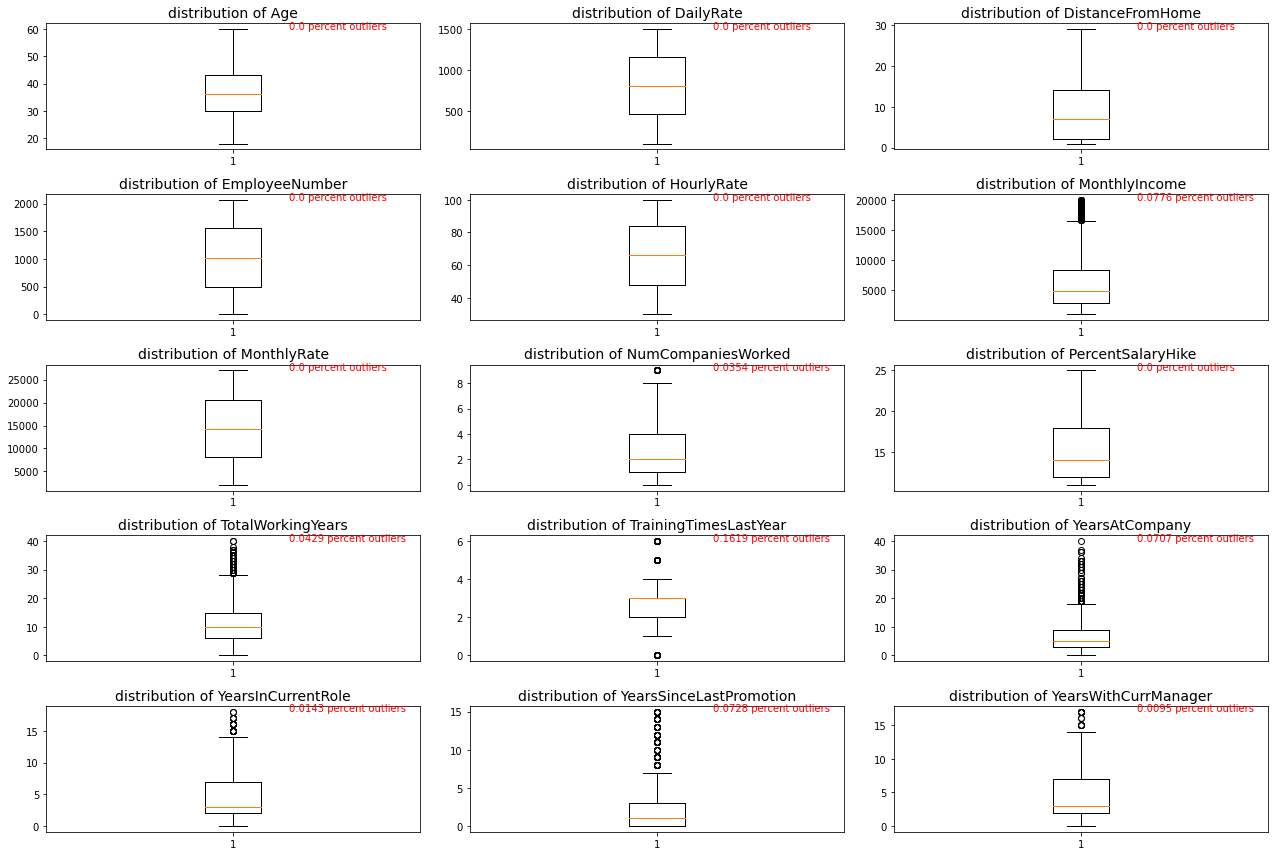

In [9]:
plotVarsDist(cleanedsrcdf['0dropped1ordinaled'],vartype='conti',chartType='boxplot',displayVars=realContiVars,figsize=(18,12))

### 尺度標準化

In [10]:
for key in ['0dropped2rbscaled','0dropped1ordinaled2rbscaled','0dropped2rbscaled2rbscaled','0dropped2rbscaled2rbscaled2rbscaled','0dropped1ordinaled2rbscaled2rbscaled','0dropped1ordinaled2rbscaled2rbscaled2rbscaled']:
    try:
        del cleanedsrcdf[key]
    except:
        pass
cleanedsrcdf.keys()

dict_keys(['0dropped', '0dropped1ordinaled'])

In [11]:
pd.set_option('display.max_columns', 5000)
scalerModel = {}
for previousTestd in copy.deepcopy(list(cleanedsrcdf.keys())): #to avoid dict change error
    print('previousTestd is {}'.format(previousTestd))
    #targetContiVars = continueousVars+ordinalVars if re.search('ordinal',previousTestd)==None else realContiVars
    #display(targetContiVars)
    #continueousVars realContiVars
    #continue
    cleanedsrcdf[previousTestd+'2rbscaled'] = cleanedsrcdf[previousTestd].loc[:,:]
    #display(cleanedsrcdf[previousTestd+'2rbscaled'])
    #continue
    #coltransformer = sklearn.compose.ColumnTransformer(ordinalColumnTransformers, remainder='passthrough', verbose_feature_names_out=False).fit(cleanedsrcdf['0dropped1ordinaled'])
    #cleanedsrcdf['0dropped1ordinaled'] = pd.DataFrame(data=coltransformer.transform(cleanedsrcdf['0dropped1ordinaled']),columns=coltransformer.get_feature_names_out())
    scalerModel[previousTestd] = sklearn.preprocessing.RobustScaler().fit(cleanedsrcdf[previousTestd+'2rbscaled'].loc[:, realContiVars])
    cleanedsrcdf[previousTestd+'2rbscaled'][realContiVars] = pd.DataFrame(
        data=scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd+'2rbscaled'].loc[:, realContiVars]),
        columns=realContiVars
        ).astype('float64')
    cleanedsrcdf[previousTestd][realContiVars] = cleanedsrcdf[previousTestd].loc[:, realContiVars].astype('float64')    

    if re.search('ordinaled',previousTestd)!=None:
        cleanedsrcdf[previousTestd+'2rbscaled'][convertedOrdinalVars] = cleanedsrcdf[previousTestd+'2rbscaled'].loc[:, convertedOrdinalVars].astype('float64')
        cleanedsrcdf[previousTestd][convertedOrdinalVars] = cleanedsrcdf[previousTestd].loc[:, convertedOrdinalVars].astype('float64')
    else:
        cleanedsrcdf[previousTestd][ordinalVars] = cleanedsrcdf[previousTestd].loc[:, ordinalVars].astype('float64')

    
    #tmpOtherVars = (newOvcolnames if re.search('ordinal',previousTestd)!=None else ordinalVars)+categoricalVars
    #tmpOtherVars = newOvcolnames if re.search('ordinal',previousTestd)!=None else categoricalVars
    #dfdata = scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd].loc[:,targetContiVars].to_numpy())
    #if dfdata.shape[1]!=len(targetContiVars):
    #    raise('not equal error')
    #cleanedsrcdf[previousTestd+'2rbscaled'] = pd.DataFrame(
    #        data=dfdata,
    #        columns=targetContiVars
    #    ).reset_index(drop=True)
    #cleanedsrcdf[previousTestd+'2rbscaled'] = cleanedsrcdf[previousTestd+'2rbscaled'].rename(columns={i:x for i,x in enumerate(targetContiVars)})
    #for col in tmpOtherVars:
    #    cleanedsrcdf[previousTestd+'2rbscaled'][col] = cleanedsrcdf[previousTestd][col].reset_index(drop=True)
    #for col in cleanedsrcdf[previousTestd+'2rbscaled'].columns: #sometime a column would becomes a dataframe
    #    if isinstance(cleanedsrcdf[previousTestd+'2rbscaled'][col],pd.core.frame.DataFrame):
    #        print('type error at {} col {}'.format(previousTestd+'2rbscaled',col))
    #        tempseries = cleanedsrcdf[previousTestd+'2rbscaled'][col].reset_index(drop=True).iloc[:,0]
    #        cleanedsrcdf[previousTestd+'2rbscaled'] = cleanedsrcdf[previousTestd+'2rbscaled'].drop(columns=[col])
    #        cleanedsrcdf[previousTestd+'2rbscaled'][col] = tempseries
    #        #display(cleanedsrcdf[previousTestd+'2rbscaled'][col])

previousTestd is 0dropped
previousTestd is 0dropped1ordinaled


In [12]:
#cleanedsrcdf['0dropped1ordinaled2rbscaled'].dtypes#.loc[:, convertedOrdinalVars] = cleanedsrcdf['0dropped1ordinaled2rbscaled'].loc[:, convertedOrdinalVars].astype('float64')
#cleanedsrcdf['0dropped1ordinaled2rbscaled'].dtypes#.loc[:, convertedOrdinalVars].dtypes

In [13]:
#cleanedsrcdf['0dropped2rbscaled']['Education']
#scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd].loc[:,targetContiVars])
#scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd].loc[:,targetContiVars].to_numpy()).shape
#len(targetContiVars)

In [14]:
#檢查是否會有明明是series卻變成dataframe的錯誤
for previousTestd,tempdf in cleanedsrcdf.items():
    for col in tempdf.columns:
        try:
            t = tempdf[col].unique()
        except Exception as e:
            print('error at previousTestd {} col {} for {}'.format(previousTestd, col, e))

## EDA

### 最開始直接什麼預處理都不作以最簡單的Random Forest嘗試作為baseline（演算法特性較不依賴特徵工程）

testsrc is 0dropped and drop_first is True
value of targetmetric average_precision is 0.5448363047275449 in avg
testsrc is 0dropped and drop_first is False
value of targetmetric average_precision is 0.5414690771068812 in avg
testsrc is 0dropped1ordinaled and drop_first is True
value of targetmetric average_precision is 0.5403071263921995 in avg
testsrc is 0dropped1ordinaled and drop_first is False
value of targetmetric average_precision is 0.5418393526565216 in avg
testsrc is 0dropped2rbscaled and drop_first is True
value of targetmetric average_precision is 0.5448363047275449 in avg
testsrc is 0dropped2rbscaled and drop_first is False
value of targetmetric average_precision is 0.5414690771068812 in avg
testsrc is 0dropped1ordinaled2rbscaled and drop_first is True
value of targetmetric average_precision is 0.5403071263921995 in avg
testsrc is 0dropped1ordinaled2rbscaled and drop_first is False
value of targetmetric average_precision is 0.5418393526565216 in avg


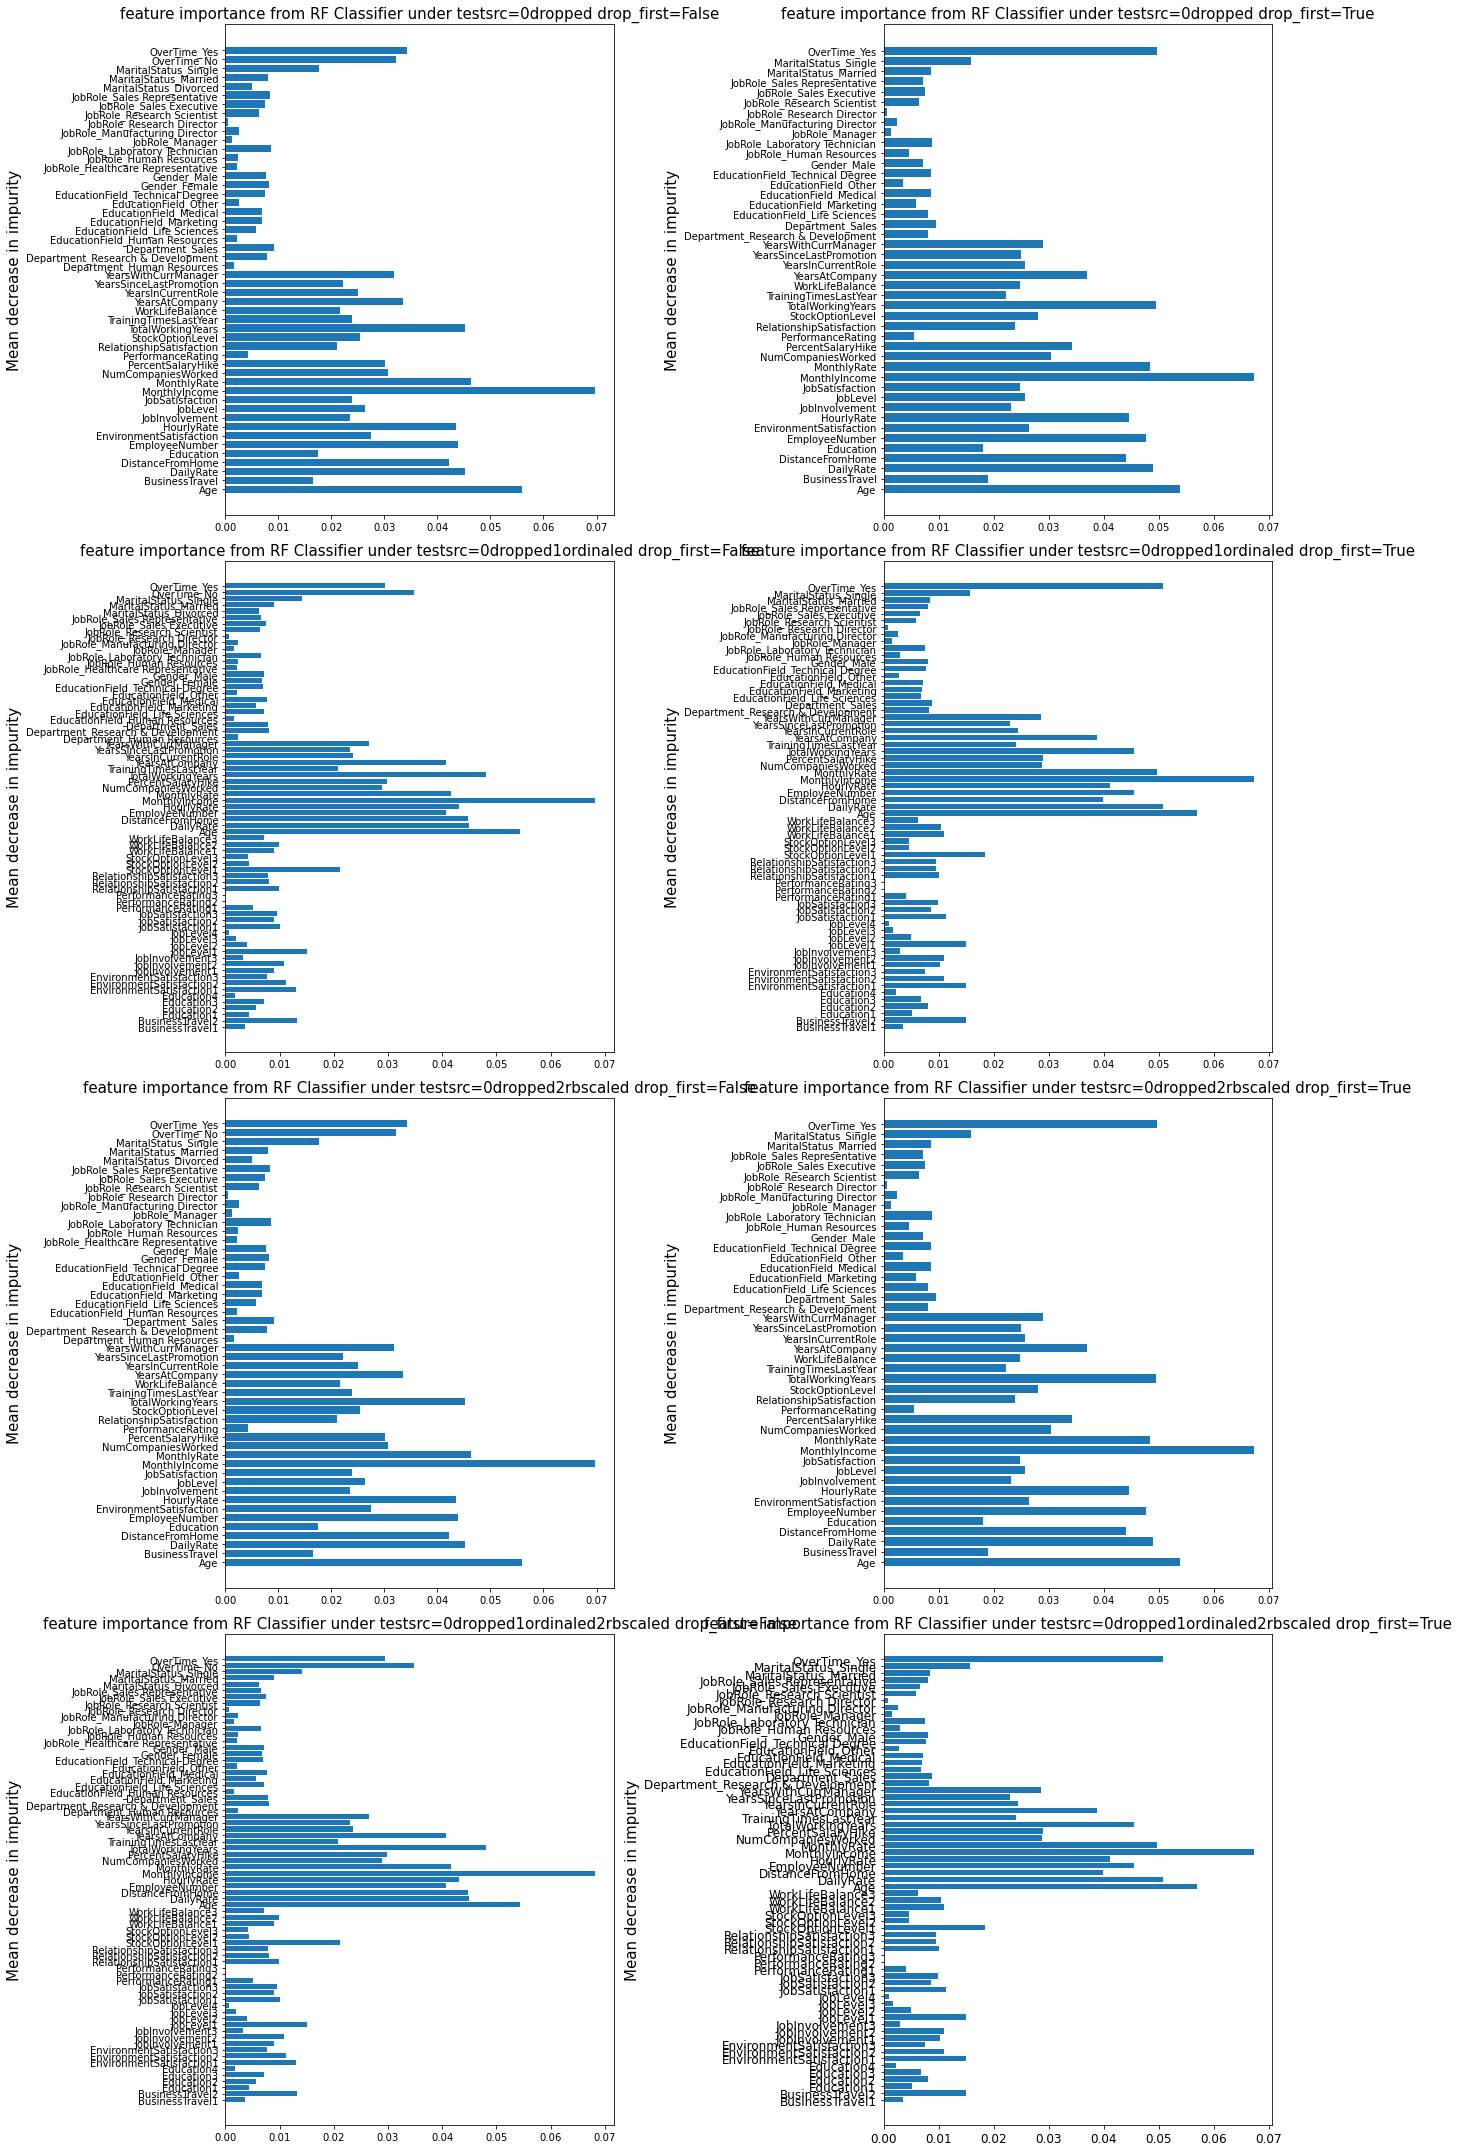

,rbscaled,drop_first,score
ordinaled,,,
False,0.5,0.5,0.543153
True,0.5,0.5,0.541073


,ordinaled,drop_first,score
rbscaled,,,
False,0.5,0.5,0.542113
True,0.5,0.5,0.542113


,ordinaled,rbscaled,score
drop_first,,,
False,0.5,0.5,0.541654
True,0.5,0.5,0.542572


,ordinaled,rbscaled,drop_first,score
metric,,,,
average_precision,0.5,0.5,0.5,0.542113


In [15]:
testnSubplotCols = 2
fig, ax = plt.subplots(len(cleanedsrcdf), testnSubplotCols, figsize=(18, 30))
figrowi=-1
datai=0
tempEvaluationDicts = []
for testsrc in cleanedsrcdf:
    iftestsrcordinaled = re.search('ordinaled',testsrc)!=None
    iftestsrcrbscaled = re.search('rbscaled',testsrc)!=None
    dummiedSrcdfX = cleanedsrcdf[testsrc]
    figrowi += 1
    for drop_first in [True,False]:
        datai += 1
        print('testsrc is {} and drop_first is {}'.format(testsrc,drop_first))
        dummiedSrcdfXAfterDrop = pd.get_dummies(dummiedSrcdfX, drop_first=drop_first)

        clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
        clf.fit(dummiedSrcdfXAfterDrop,y=lbzedSrcdfY)
        std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
        ax[figrowi][datai%testnSubplotCols].barh(dummiedSrcdfXAfterDrop.columns, clf.feature_importances_, xerr=std, align='center')

        ax[figrowi][datai%testnSubplotCols].set_title("feature importance from RF Classifier under testsrc={} drop_first={}".format(testsrc, drop_first), fontsize=15)
        ax[figrowi][datai%testnSubplotCols].set_ylabel("Mean decrease in impurity", fontsize=15)
        plt.xticks(fontsize=12, rotation=0)
        plt.yticks(fontsize=12, rotation=0)
        for targetmetric in ['average_precision']: #'accuracy','f1','roc_auc','balanced_accuracy',
            cvscores = sklearn.model_selection.cross_val_score(clf, dummiedSrcdfXAfterDrop, lbzedSrcdfY, cv=5, scoring=targetmetric)
            print('value of targetmetric {} is {} in avg'.format(
                targetmetric,
                np.mean(cvscores)
                ))
            tempEvaluationDicts.append({'ordinaled':iftestsrcordinaled, 'rbscaled':iftestsrcrbscaled, 'metric':targetmetric, 'drop_first':drop_first, 'score':np.mean(cvscores)})
plt.tight_layout()
plt.show()
pretestMetrics = pd.DataFrame.from_records(tempEvaluationDicts)
#for testAttr in ['ordinaled','rbscaled','drop_first']:
testAttrs = ['ordinaled','rbscaled','drop_first','metric']
for testAttr in testAttrs:
    display(pretestMetrics.groupby(testAttr).agg('mean'))

#### 變數之間相關圖

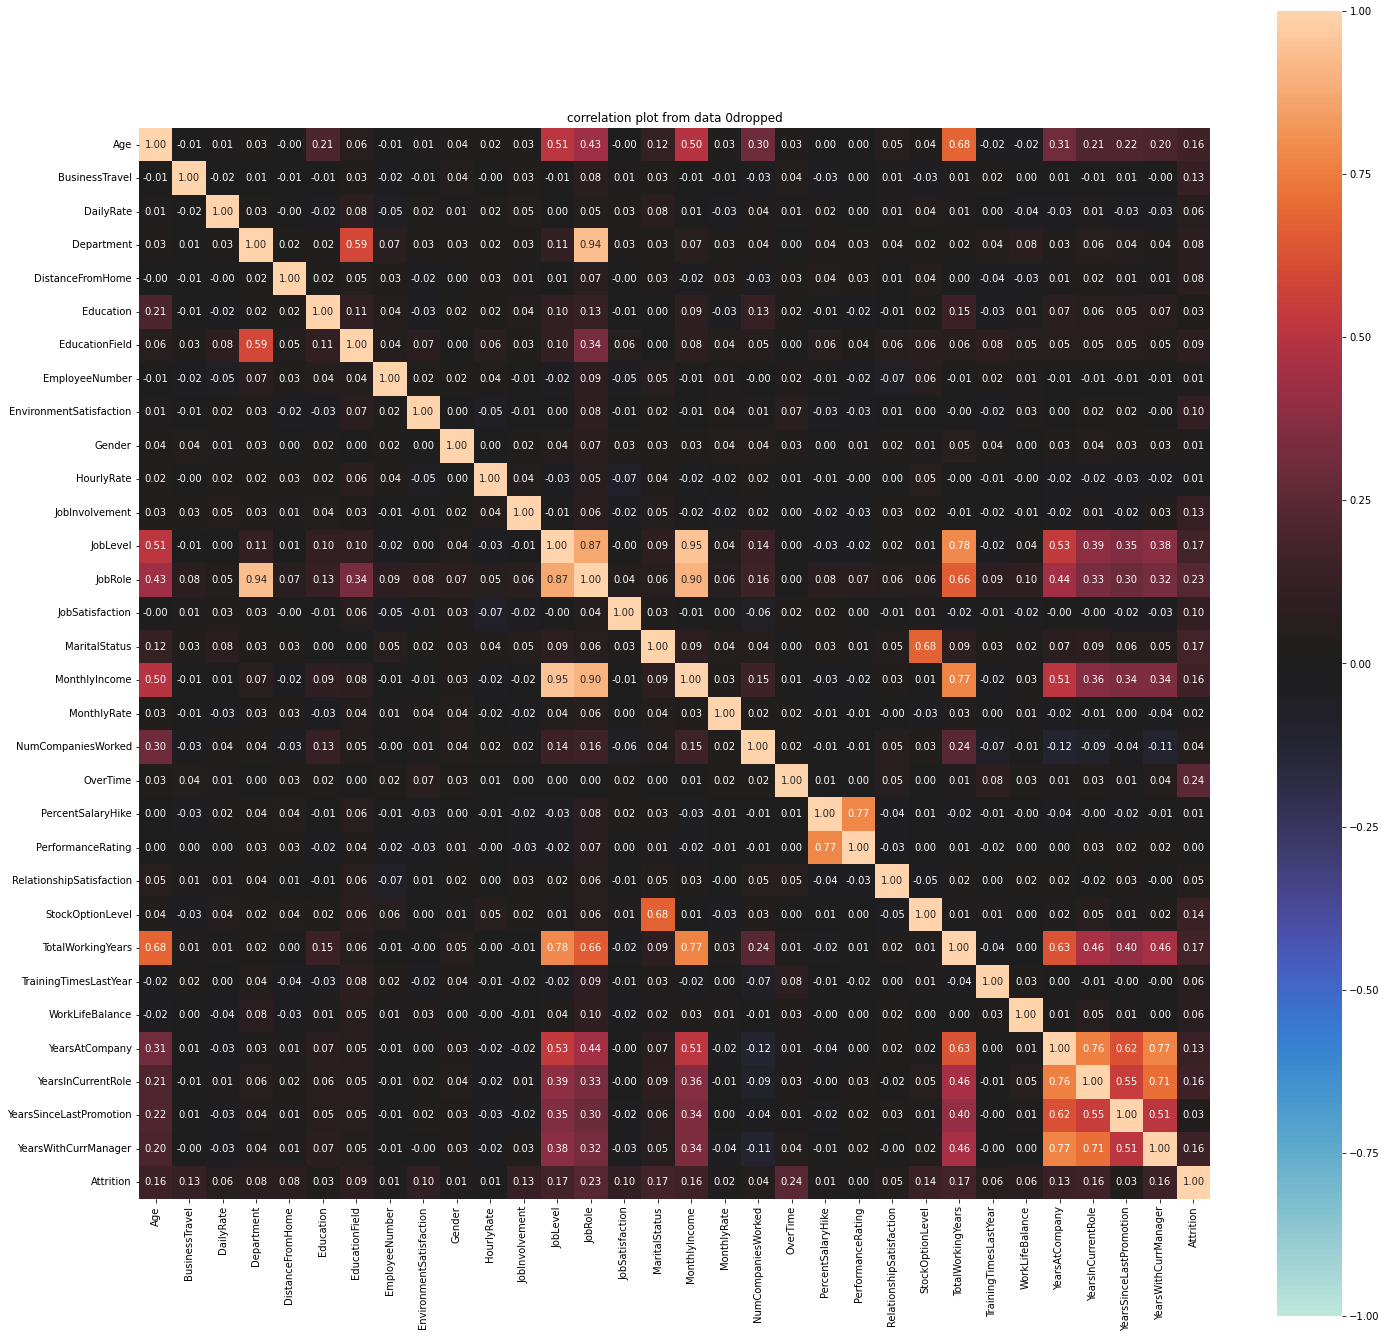

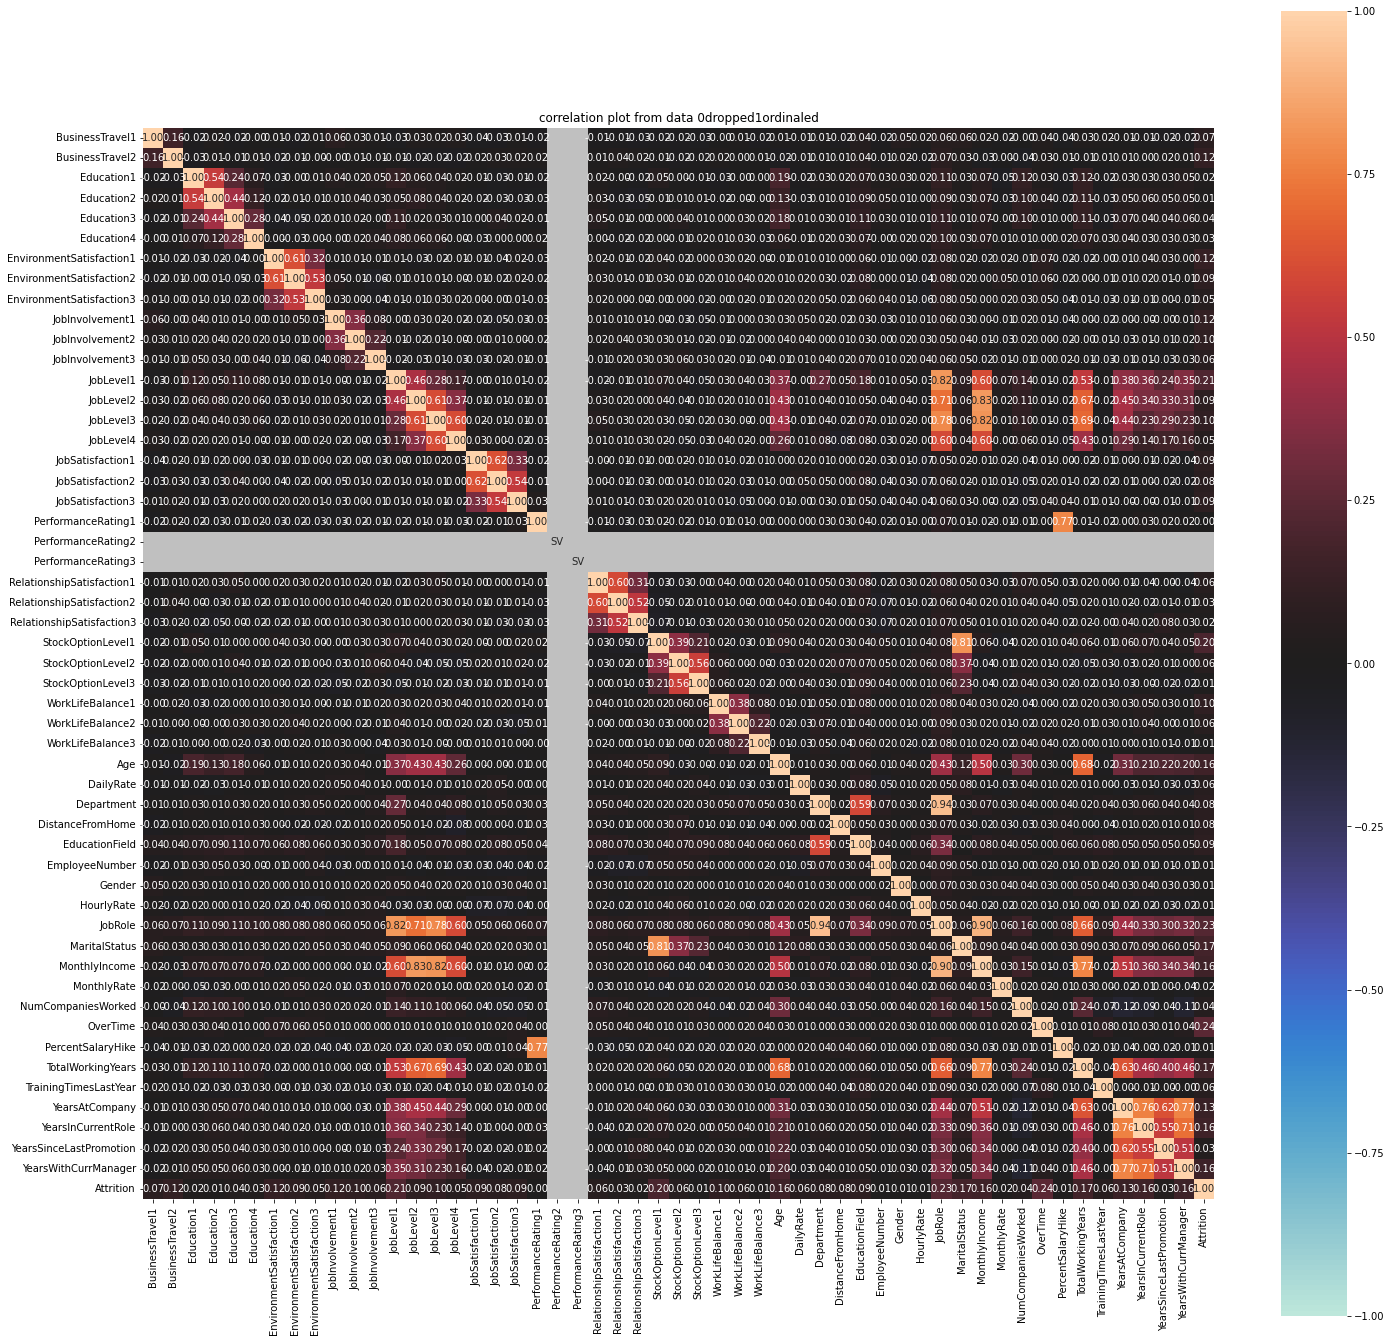

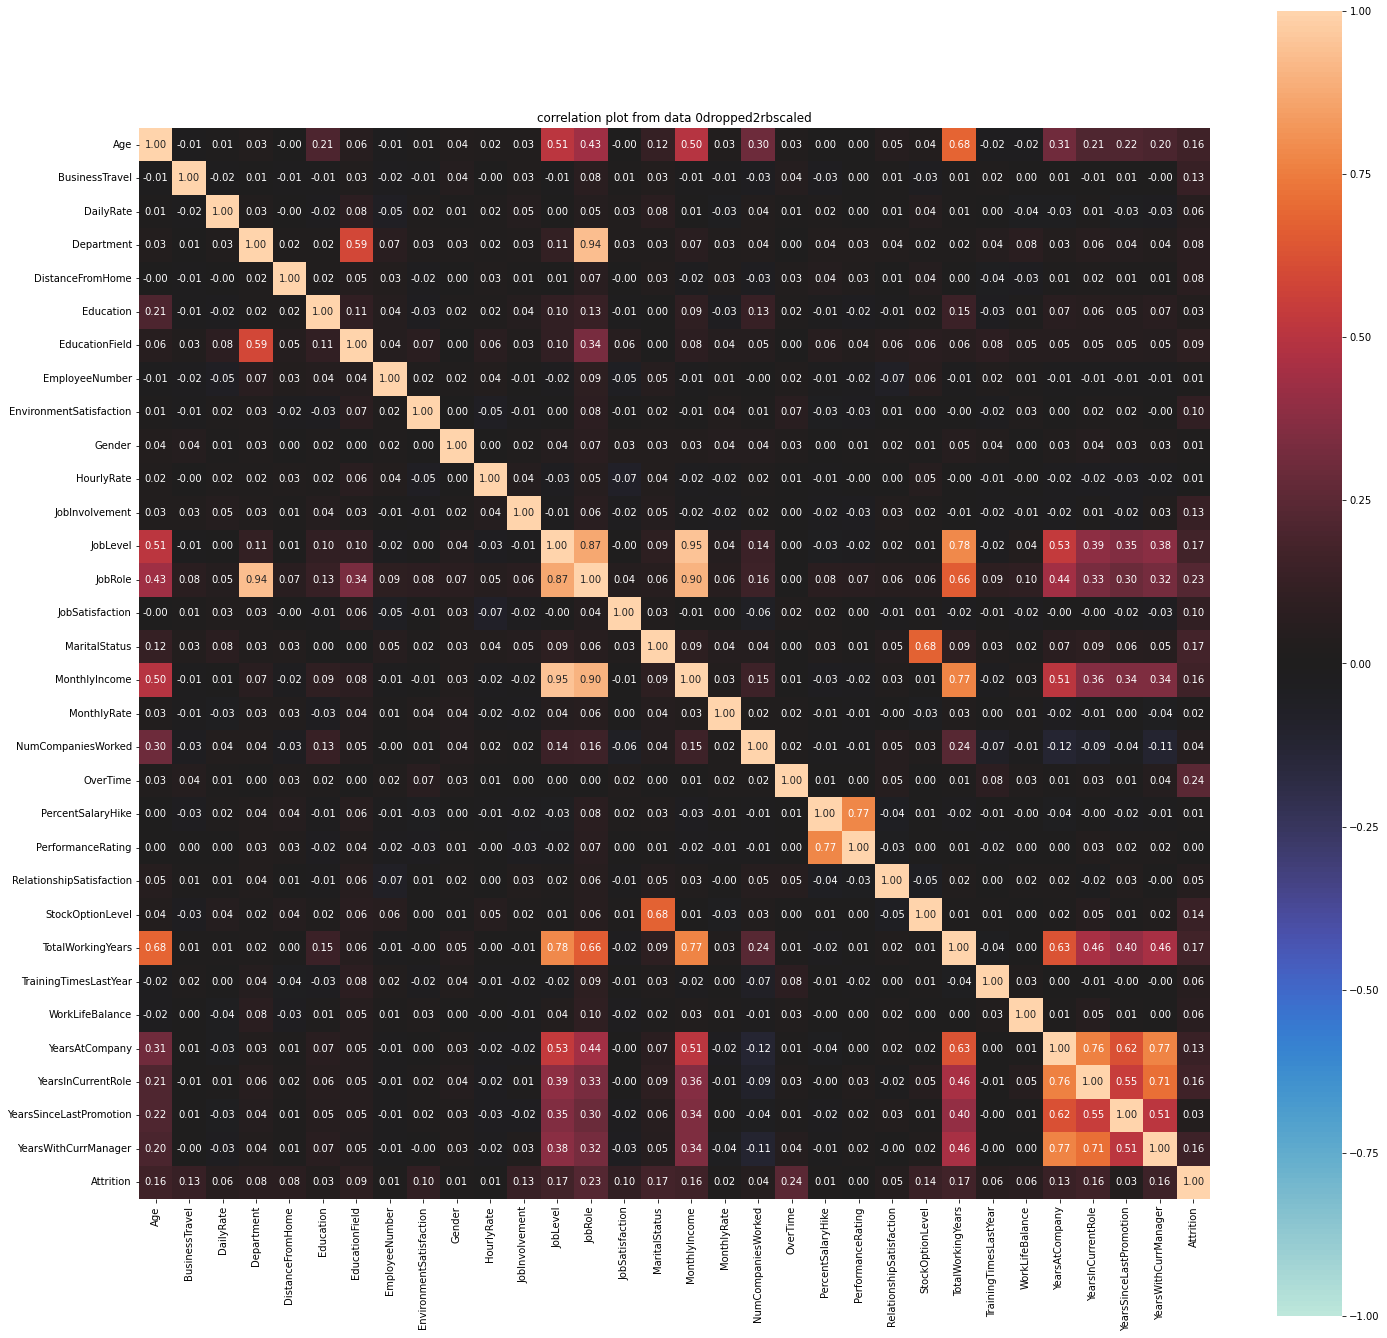

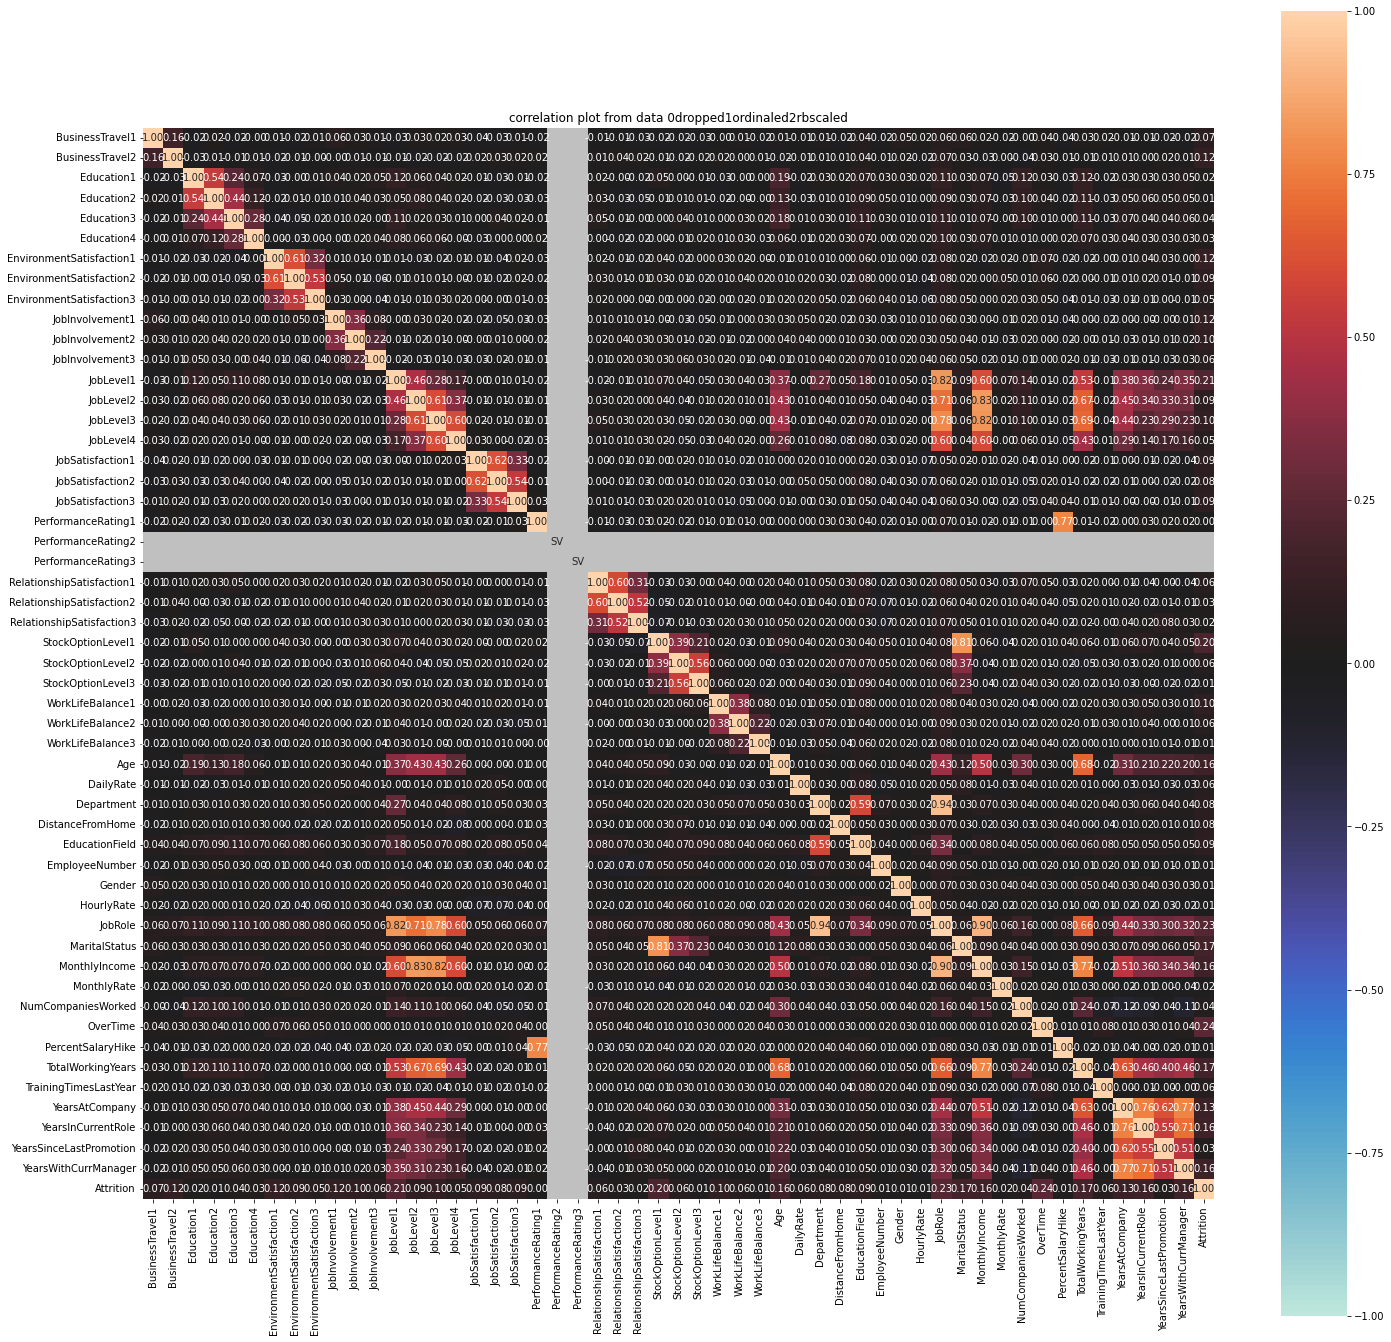

In [ ]:
for previousTestd in cleanedsrcdf.keys():
    dython.nominal.associations(
        pd.concat([cleanedsrcdf[previousTestd], srcdfY], axis=1).reset_index(drop=True),
        #cleanedsrcdf[previousTestd],
        figsize=(24,24), title=f'correlation plot from data {previousTestd}')

#pd.plotting.scatter_matrix(cleanedsrcdf['0dropped1ordinaled2rbscaled'], figsize=(40,40), marker = 'o', hist_kwds = {'bins': 50}, s = 60, alpha = 0.9)

可以看到1.在公司與職位年資 2.職務等級與工資率 是明顯彼此高度相關有重疊的指標，意味著要構面縮減時至少可以分門別類將這些指標各自縮成同一個構面（例如前者縮成【在公司與職務資深度】，後者縮成【階級】）


### 構面縮減

#### 傳統PCA（供參考，不實際使用）

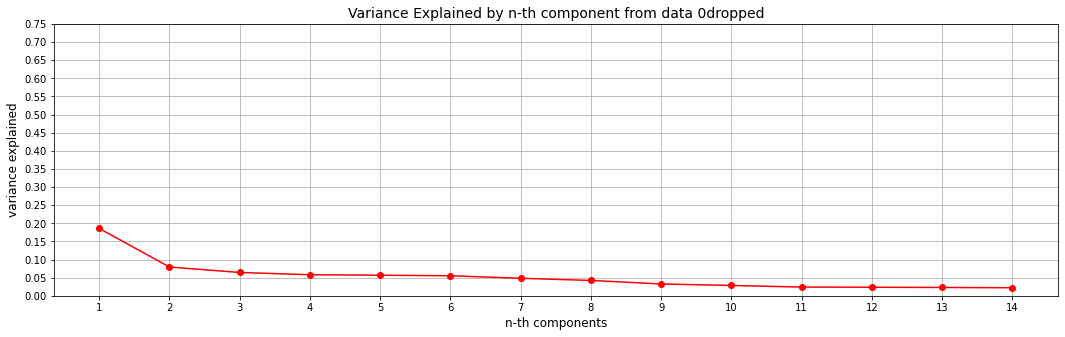

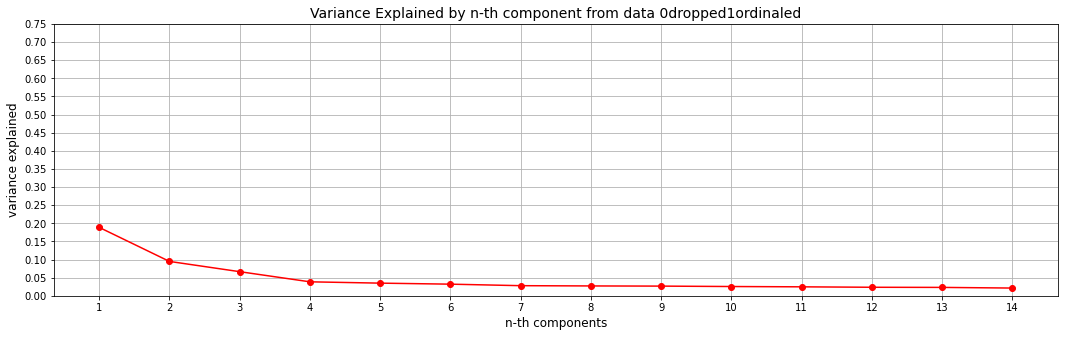

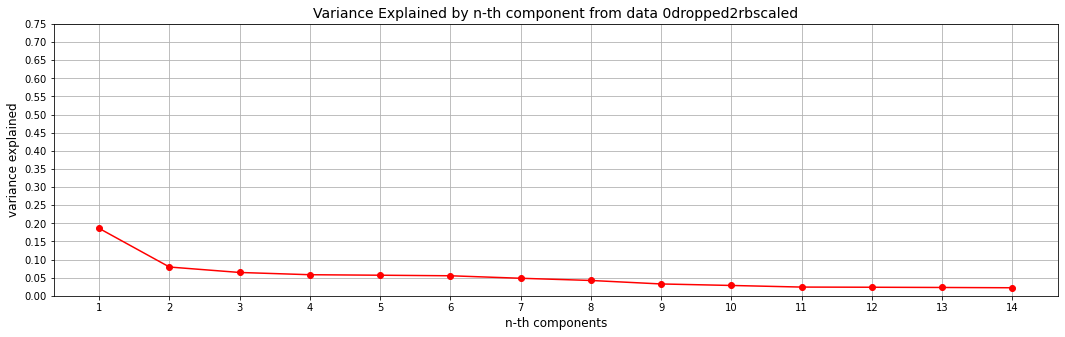

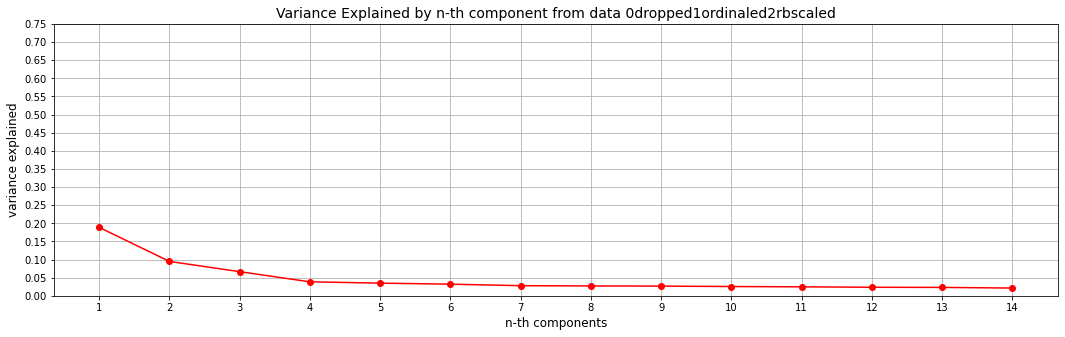

In [16]:
pcaTestRangeMax = 15
pcaTestRange = np.arange(1,pcaTestRangeMax,1)
pcaTransformers = {}

for previousTestd in cleanedsrcdf:
    pcaTransformers[previousTestd] = {n:sklearn.decomposition.PCA(n, random_state=0).fit(pd.get_dummies(cleanedsrcdf[previousTestd])) for n in pcaTestRange}
    plt.figure(figsize=(18, 5))
    plt.plot(pcaTestRange,pcaTransformers[previousTestd][pcaTestRange[-1]].explained_variance_ratio_, color='red', marker='o')
    plt.xticks(pcaTestRange)
    plt.yticks(np.arange(0,0.8,0.05))
    plt.grid(True)
    plt.title(f'Variance Explained by n-th component from data {previousTestd}', fontsize=14)
    plt.xlabel('n-th components', fontsize=12)
    plt.ylabel('variance explained', fontsize=12)

4個component可解釋變異約僅 0.1875+0.1+0.069+0.05=0.4065

In [ ]:
if False:
    kpcaTransformer = sklearn.decomposition.KernelPCA(n_components=12,kernel='rbf').fit_transform(pd.get_dummies(cleanedsrcdf['0dropped1ordinaled2rbscaled']).astype('float64'))
    cleanedsrcdf['0dropped1ordinaled2rbscaled3pca'] = kpcaTransformer
    print(cleanedsrcdf['0dropped1ordinaled2rbscaled3pca'].shape)

#### 透過 Variational AutoEncoder 構面縮減

In [ ]:
from apps.attritionml.mlmodeldefinition import getVaeEncoder,getVaeModel
vae_built_on_data_type = '0dropped2rbscaled'

#### 先顯示原本的維度

In [ ]:
for dfkey in [key for key in cleanedsrcdf.keys() if re.search('scaled',key)!=None]:
    display('key {} shape is {} and after dummies shape is {}'.format(dfkey, cleanedsrcdf[dfkey].shape, pd.get_dummies(cleanedsrcdf[dfkey]).shape), cleanedsrcdf[dfkey].dtypes)

#### 根據可能縮減的維度設定VAE

In [ ]:
if False:
    fitdata = pd.get_dummies(cleanedsrcdf[vae_built_on_data_type]).astype('float64').to_numpy()
    vaeFittingRes = {}
    vaeModels = {}
    dimsToLoss = {}
    for ldim in [4,8,12,24,32,64]:
        vaeModels[ldim] = getVaeModel(ldim, fitdata.shape[1])
        earlystopcallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=60, verbose=1, mode='min', restore_best_weights=True)
        reducelrcallback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.6,patience=15,verbose=1)
        vaeFittingRes[ldim] = vaeModels[ldim].fit(x=fitdata, y=fitdata, epochs=3000, batch_size=64, callbacks=[earlystopcallback,reducelrcallback])
        dimsToLoss[ldim] = min(vaeFittingRes[ldim].history['loss'])
        print('min loss at dim {} is {}'.format(ldim, dimsToLoss[ldim]))
        vaeModels[ldim].save('vae-dim{}-loss{}.h5'.format(ldim,dimsToLoss[ldim]))

Epoch 1/3000
23/23 [==============================] - 3s 33ms/step - loss: 1450.8822 - lr: 5.0000e-04
Epoch 2/3000
23/23 [==============================] - 1s 32ms/step - loss: 1204.4844 - lr: 5.0000e-04
Epoch 3/3000
23/23 [==============================] - 1s 31ms/step - loss: 1032.5665 - lr: 5.0000e-04
Epoch 4/3000
23/23 [==============================] - 1s 31ms/step - loss: 901.0013 - lr: 5.0000e-04
Epoch 5/3000
23/23 [==============================] - 1s 31ms/step - loss: 798.9980 - lr: 5.0000e-04
Epoch 6/3000
23/23 [==============================] - 1s 31ms/step - loss: 721.0579 - lr: 5.0000e-04
Epoch 7/3000
23/23 [==============================] - 1s 32ms/step - loss: 664.2380 - lr: 5.0000e-04
Epoch 8/3000
23/23 [==============================] - 1s 31ms/step - loss: 613.1290 - lr: 5.0000e-04
Epoch 9/3000
23/23 [==============================] - 1s 31ms/step - loss: 570.2828 - lr: 5.0000e-04
Epoch 10/3000
23/23 [==============================] - 1s 32ms/step - loss: 540.1841 - l

實驗紀錄
* best by relu batchsize 64 and 4 hidden size is 174.5532
* best by leakyrelu batchsize 64 and 4 hidden size is 167.0726
* best by selu batchsize 64 and 4 hidden size is 167.0726
* best by Prelu batchsize 64 and 4 hidden size is 164.8862
* best by CNN batchsize and 4 hidden size 64 is 164.6893
* best by Prelu batchsize 64 loss and 6 hidden size: 154.1259
* best by Prelu batchsize 64 loss and 10 hidden size: 129.8
* best by Prelu batchsize 64 loss and 16 hidden size: 129.8
* {4: 161.62901306152344, 8: 138.72447204589844, 12: 118.9158706665039, 16: 103.81063842773438, 32: 99.14110565185547}
* {4: 192.1639862060547, 8: 144.4535675048828, 12: 117.8581771850586, 24: 107.50943756103516, 32: 92.59283447265625, 64: 101.70317077636719}

In [ ]:
def plotTrainingHistory(trainhistory):
    plt.plot(trainhistory.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
if False:
    display(dimsToLoss)

{4: 192.1639862060547,
 8: 144.4535675048828,
 12: 117.8581771850586,
 24: 107.50943756103516,
 32: 92.59283447265625,
 64: 101.70317077636719}

In [ ]:
if False:
    encoder_reconstructed = getVaeModel(32,pd.get_dummies(cleanedsrcdf[vae_built_on_data_type]).astype('float64').shape[1])
    encoder_reconstructed.load_weights('vae-dim32-loss92.59283447265625.h5')
    encoder_reconstructed = tf.keras.models.Sequential(encoder_reconstructed.layers[:2])
    encoder_reconstructed.summary()
    #custom_objects={'Sampling':Sampling,'vae_loss':vae_loss}

In [ ]:
#dimReductionByVAE = 
#t = pd.get_dummies(cleanedsrcdf[srcdftype]).astype('float64')
#sys.exit()
if False:

    for srcdftype in [vae_built_on_data_type]:
        newsrcdftype = srcdftype+'4vae'
        cleanedsrcdf[newsrcdftype] = encoder_reconstructed.predict(pd.get_dummies(cleanedsrcdf[srcdftype]).astype('float64'))
        display('orig shape {} vae to {}'.format(cleanedsrcdf[srcdftype].shape,cleanedsrcdf[newsrcdftype].shape))

## Modeling

#### 因為標籤分布不均所以計算並使用class weight與sample weight

In [17]:
attrition_classWeights = sklearn.utils.class_weight.compute_class_weight('balanced',classes=np.unique(lbzedSrcdfY),y=lbzedSrcdfY)
#attrition_classWeights
attrition_classWeights_dict = dict(zip(np.unique(lbzedSrcdfY),attrition_classWeights))
attrition_sampleweights = sklearn.utils.class_weight.compute_sample_weight(attrition_classWeights_dict, y=lbzedSrcdfY)
display(attrition_classWeights_dict, attrition_sampleweights)

{0: 0.5961070559610706, 1: 3.1012658227848102}

array([3.10126582, 0.59610706, 3.10126582, ..., 0.59610706, 0.59610706,
       0.59610706])

## Pipeline 超參數網格搜尋
* 參考：https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline
* 使用 average_precision_score 針對資料不平衡情形評估模型成效

In [19]:
from drive.MyDrive.ColabNotebooks import tfClfModeling
importlib.reload(tfClfModeling)

class ClfSwitcher(sklearn.base.BaseEstimator):
    def __init__(
        self, 
        estimator = sklearn.linear_model.SGDClassifier(),
        class_weight = None,
        sample_weight = None,
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        super(ClfSwitcher).__init__()
        self.estimator = estimator
        self.sample_weight = sample_weight
        self.class_weight = class_weight
    def newXandSampleWeight(self, X):
        if self.sample_weight==True:
            sample_weight = X['sampleweight']
        else:
            sample_weight = None
        X = X.drop(columns='sampleweight')
        self.sample_weight_values = sample_weight
        return X, sample_weight
    def fit(self, X, y=None, **kwargs): #
        X,kwargs['sample_weight'] = self.newXandSampleWeight(X)
        try:
            self.estimator.fit(X, y, **kwargs)
        except Exception as e:
            print(e)
            self.estimator.fit(X, y)
        return self
    def predict(self, X, y=None):
        X = X.drop(columns='sampleweight')
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def score(self, X, y, sample_weight=None):
        X,sample_weight = self.newXandSampleWeight(X)
        y_score = self.estimator.predict_proba(X)
        try:
          y_score = y_score[:, -1]
        except Exception as e:
          print(str(e))
          y_score = y_score
        average_precision = sklearn.metrics.average_precision_score(y, y_score, sample_weight=sample_weight)
        return average_precision

class tfkerasClf(sklearn.base.BaseEstimator):
    def __init__(
        self,
        class_weight=None,
        sample_weight=None,
        denseLayerUnits=None,
        lastLayerUnits=None,
        l2Alpha=None,
        dropout_rate=None,
        batch_size=None,
        metrics=None,
        epochs=None,
        validation_split=None,
        callbacks=None,
        weighted_metrics=None,
        lastLayerActivation=None,#tf.keras.activations.sigmoid,
        activation=None,#tf.keras.activations.relu,
        optimizer=None,#tf.keras.optimizers.Adam(),
        loss=None,#tf.keras.losses.BinaryCrossentropy(),
    ):
        super(tfkerasClf).__init__()
        """
        https://scikit-learn.org/stable/developers/develop.html
        every keyword argument accepted by __init__ should correspond to an attribute on the instance. Scikit-learn relies on this to find the relevant attributes to set on an estimator when doing model selection.
        """
        self.sample_weight = sample_weight
        self.class_weight = class_weight
        self.denseLayerUnits = denseLayerUnits
        self.lastLayerUnits = lastLayerUnits
        self.lastLayerActivation = lastLayerActivation
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.l2Alpha = l2Alpha
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.weighted_metrics = weighted_metrics
        self.epochs = epochs
        self.callbacks = callbacks
        self.validation_split = validation_split
        self.modelKwargs = self.get_params(deep=True)
    def fit(self, X, y=None, **kwargs):
        if True:
          #additionalKwargs = {
          #    'batch_size': self.modelKwargs['batch_size'],
          #    'epochs': self.modelKwargs['epochs'],
          #    'validation_split': self.modelKwargs['validation_split'],
          #    'callbacks': self.modelKwargs['callbacks'],
          #}
          allkwargs = {**self.modelKwargs, **kwargs} #kwargs contains sample_weight and merging dict is for it
        pool = multiprocessing.Pool(1)
        process = pool.apply_async(tfClfModeling.ind_tfkerasClf, (X, ), {'y':y, 'kwargs':allkwargs})
        ts,self.modelfilepath = process.get()
        pool.close()
        print(f'res is {self.modelfilepath}')
        #self.buildModel(X)
        #tf.keras.backend.clear_session()
        #tf.config.experimental.reset_memory_stats('GPU:0')
        #self.model.fit(X, y, **allkwargs)
        return self
    def predict(self, X, y=None):
        y_pred = self.predict_proba(X)
        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0
        #self.model = tf.keras.models.load_model(self.modelfilepath)
        #y_pred = self.model.predict(X)
        #y_pred = y_pred.argmax(axis=-1)
        return y_pred
    def predict_proba(self, X):
        #self.model = tf.keras.models.load_model(self.modelfilepath)
        pool = multiprocessing.Pool(1)
        process = pool.apply_async(tfClfModeling.loadmodelAndPredict, (X, self.modelfilepath,))
        y_pred = process.get()
        pool.close()
        return y_pred

pipeline = sklearn.pipeline.Pipeline([
    ('clf', ClfSwitcher()),
])
tfkerasparameters = [
    {
        'clf__estimator': [tfkerasClf()],
        'clf__estimator__denseLayerUnits': [[10,10],[20,20]],
        'clf__estimator__lastLayerUnits': [1],
        'clf__estimator__validation_split': [0.1],
        'clf__estimator__l2Alpha': [0.01,0.0001],
        'clf__estimator__dropout_rate': [0.0, 0.15],
        'clf__estimator__batch_size': [96],
        'clf__estimator__epochs': [50],
        'clf__estimator__metrics': [None],
        'clf__sample_weight': [False,True],
        'clf__estimator__activation': [
          {'activation':'relu'}
        ],
        'clf__estimator__lastLayerActivation': [
          {'activation':'sigmoid'}
        ],
        'clf__estimator__optimizer': [
          {'optimizer':'Adam','parameters':{}}
        ],
        #'clf__estimator__callbacks': [[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)]],
        'clf__estimator__callbacks': [
          [
           {'callback':'EarlyStopping','parameters':{'monitor':'val_loss','patience':10,'mode':'min','restore_best_weights':True}}
          ]
        ],
        #'clf__estimator__weighted_metrics': [[tf.keras.metrics.AUC(curve='PR',name='AUC-PR'),tf.keras.metrics.Recall(name='recall')]],
        'clf__estimator__weighted_metrics': [
          [
           {'metric':'AUC','parameters':{'curve':'PR','name':'AUC-PR'}},
           {'metric':'Recall','parameters':{'name':'recall'}}
          ]
        ],
        #'clf__estimator__loss': [tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'), tf.keras.losses.BinaryFocalCrossentropy(name='binary_focal_crossentropy')],
        'clf__estimator__loss': [{'loss':'binary_crossentropy'},{'loss':'binary_focal_crossentropy'}]
    },
]
parameters = [

    {
        'clf__estimator': [sklearn.svm.SVC()],
        'clf__estimator__C': [0.5,1.0,3.0,10.0],
        'clf__estimator__kernel': ['poly', 'rbf'],
        'clf__estimator__probability': [True],
        'clf__sample_weight': [False, True],
    },
    {
        'clf__estimator': [sklearn.ensemble.RandomForestClassifier()],
        'clf__estimator__max_depth': [None,5,10,20],
        'clf__estimator__min_samples_split': [2,10],
        'clf__estimator__min_samples_leaf': [1,2,10],
        'clf__sample_weight': [False, True],
    },
    {
        'clf__estimator': [sklearn.linear_model.LogisticRegression()],
        'clf__estimator__penalty': ['elasticnet','none'],
        'clf__estimator__solver': ['saga'],
        'clf__estimator__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0],
        'clf__sample_weight': [False, True],
    },
    {
        'clf__estimator': [sklearn.linear_model.SGDClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__estimator__penalty': ['elasticnet'],
        'clf__estimator__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0],
        'clf__estimator__max_iter': [1000],
        'clf__estimator__tol': [1e-4],
        'clf__estimator__loss': ['modified_huber'],
        'clf__sample_weight': [False, True],
    },
    {
        'clf__estimator': [sklearn.ensemble.AdaBoostClassifier()],
        'clf__estimator__n_estimators': [10,50],
        'clf__estimator__learning_rate': [0.5,1.0],
        'clf__sample_weight': [False, True],
    },
]
gridsearchresdf = []
for drop_first in [True, False]:
    for dfkey in [key for key in cleanedsrcdf.keys() if re.search('scale',key)!=None]:
        gridcvdata = pd.get_dummies(cleanedsrcdf[dfkey], drop_first=drop_first)
        gridcvdata['sampleweight'] = attrition_sampleweights
        #display(gridcvdata.columns)
        #sys.exit()
        #display(gridcvdata.shape)
        print(f'drop_first {drop_first} dfkey {dfkey}')
        #difference in fitting sklearn models and tensorflow models
        for gridsearchparameterPair in [(parameters,5),(tfkerasparameters,1)]: #
            gridsearchparameter, n_jobs = gridsearchparameterPair #made difference in n_jobs due to gpu memory limits 
            gscv = sklearn.model_selection.GridSearchCV(pipeline, gridsearchparameter, cv=2, n_jobs=n_jobs, return_train_score=False, verbose=3)
            gscv.fit(gridcvdata, lbzedSrcdfY)
            tempdf = pd.DataFrame(gscv.cv_results_)
            tempdf['dfkey'] = dfkey
            tempdf['drop_first'] = drop_first
            gridsearchresdf.append(tempdf)
gridsearchresdf = pd.concat(gridsearchresdf, axis=0).reset_index(drop=True).sort_values(by='mean_test_score', ascending=False)
display(gridsearchresdf)
gridsearchresdf.to_csv('gridsearchresdf.csv')

Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 0.4058 - AUC-PR: 0.1909 - recall: 0.5149 - val_loss: 0.2148 - val_AUC-PR: 0.3749 - val_recall: 0.4444
Epoch 7/50
7/7 [==============================] - 0s 16ms/step - loss: 0.3479 - AUC-PR: 0.2627 - recall: 0.5545 - val_loss: 0.2053 - val_AUC-PR: 0.3738 - val_recall: 0.4444
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.3317 - AUC-PR: 0.2588 - recall: 0.5446 - val_loss: 0.1984 - val_AUC-PR: 0.3788 - val_recall: 0.3889
Epoch 9/50
7/7 [==============================] - 0s 10ms/step - loss: 0.3101 - AUC-PR: 0.2743 - recall: 0.5941 - val_loss: 0.1930 - val_AUC-PR: 0.3808 - val_recall: 0.3333
Epoch 10/50
7/7 [==============================] - 0s 17ms/step - loss: 0.2908 - AUC-PR: 0.2652 - recall: 0.5644 - val_loss: 0.1891 - val_AUC-PR: 0.3798 - val_recall: 0.2222
Epoch 11/50
7/7 [==============================] - 0s 14ms/step - loss: 0.2636 - AUC-PR: 0.3004 - recall: 0.5050 - val_loss: 0.1862 - 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__C,param_clf__estimator__kernel,param_clf__estimator__probability,param_clf__sample_weight,param_clf__estimator__max_depth,param_clf__estimator__min_samples_leaf,param_clf__estimator__min_samples_split,param_clf__estimator__l1_ratio,param_clf__estimator__penalty,param_clf__estimator__solver,param_clf__estimator__loss,param_clf__estimator__max_iter,param_clf__estimator__tol,param_clf__estimator__learning_rate,param_clf__estimator__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,dfkey,drop_first,param_clf__estimator__activation,param_clf__estimator__batch_size,param_clf__estimator__callbacks,param_clf__estimator__denseLayerUnits,param_clf__estimator__dropout_rate,param_clf__estimator__epochs,param_clf__estimator__l2Alpha,param_clf__estimator__lastLayerActivation,param_clf__estimator__lastLayerUnits,param_clf__estimator__metrics,param_clf__estimator__optimizer,param_clf__estimator__validation_split,param_clf__estimator__weighted_metrics
215,0.429720,0.004943,0.014885,0.000028,"LogisticRegression(l1_ratio=1.0, penalty='elas...",NaN,NaN,NaN,True,NaN,NaN,NaN,1.0,elasticnet,saga,NaN,NaN,NaN,NaN,NaN,{'clf__estimator': LogisticRegression(l1_ratio...,0.856054,0.855233,0.855644,0.000410,1,0dropped1ordinaled2rbscaled,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,0.320812,0.011724,0.019441,0.008262,"LogisticRegression(l1_ratio=1.0, penalty='elas...",NaN,NaN,NaN,True,NaN,NaN,NaN,0.75,elasticnet,saga,NaN,NaN,NaN,NaN,NaN,{'clf__estimator': LogisticRegression(l1_ratio...,0.855730,0.855209,0.855469,0.000261,2,0dropped1ordinaled2rbscaled,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,0.379527,0.034471,0.018227,0.000934,"LogisticRegression(l1_ratio=1.0, penalty='elas...",NaN,NaN,NaN,True,NaN,NaN,NaN,0.5,elasticnet,saga,NaN,NaN,NaN,NaN,NaN,{'clf__estimator': LogisticRegression(l1_ratio...,0.855455,0.855307,0.855381,0.000074,3,0dropped1ordinaled2rbscaled,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,0.844532,0.031359,0.029917,0.008880,"LogisticRegression(l1_ratio=1.0, penalty='elas...",NaN,NaN,NaN,True,NaN,NaN,NaN,0.25,elasticnet,saga,NaN,NaN,NaN,NaN,NaN,{'clf__estimator': LogisticRegression(l1_ratio...,0.855308,0.855276,0.855292,0.000016,4,0dropped1ordinaled2rbscaled,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.296504,0.015865,0.010869,0.004997,"LogisticRegression(l1_ratio=1.0, penalty='elas...",NaN,NaN,NaN,True,NaN,NaN,NaN,0,elasticnet,saga,NaN,NaN,NaN,NaN,NaN,{'clf__estimator': LogisticRegression(l1_ratio...,0.855036,0.854950,0.854993,0.000043,5,0dropped1ordinaled2rbscaled,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.248073,0.016165,0.000000,0.000000,"tfkerasClf(activation={'activation': 'relu'}, ...",NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,{'loss': 'binary_focal_crossentropy'},NaN,NaN,NaN,NaN,{'clf__estimator': tfkerasClf(activation={'act...,NaN,NaN,NaN,NaN,4,0dropped2rbscaled,True,{'activation': 'relu'},96,"[{'callback': 'EarlyStopping', 'parameters': {...","[20, 20]",0.15,50,0.01,{'activation': 'sigmoid'},1,None,"{'optimizer': 'Adam', 'parameters': {}}",0.1,"[{'metric': 'AUC', 'parameters': {'curve': 'PR..."
130,0.236171,0.020658,0.000000,0.000000,"tfkerasClf(activation={'activation': 'relu'}, ...",NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,{'loss': 'binary_crossentropy'},NaN,NaN,NaN,NaN,{'clf__estimator': tfkerasClf(activation={'act...,NaN,NaN,NaN,NaN,3,0dropped2rbscaled,True,{'activation': 'relu'},96,"[{'callback': 'EarlyStopping', 'parameters': {...","[20, 20]",0.15,50,0.0001,{'activation': 'sigmoid'},1,None,"{'optimizer': 'Adam', 'parameters': {}}",0.1,"[{'metric': 'AUC', 'parameters': {'curve': 'PR..."
131,0.262887,0.007515,0.000000,0.000000

### 測試VAE降維之後預測成效，結果顯示沒有提升（可能原因是VAE導致資訊損失）

In [ ]:
gridcvdataDimReducted = encoder_reconstructed.predict(pd.get_dummies(cleanedsrcdf[vae_built_on_data_type]).astype('float64'))
gridcvdataDimReducted = pd.DataFrame(gridcvdataDimReducted)
gridcvdataDimReducted['sampleweight'] = attrition_sampleweights
gscv = sklearn.model_selection.GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3)
gscv.fit(gridcvdataDimReducted, lbzedSrcdfY)
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_score', ascending=False)

### 依照上面找到表現最佳的超參數建模並存檔

In [ ]:
#param_clf__estimator	param_clf__sample_weight	param_clf__estimator__penalty
#LogisticRegression()	True	                    l2

attritionClassifier = sklearn.linear_model.LogisticRegression(penalty='l2')
attritionClassifier.fit(gridcvdata.drop(columns='sampleweight'), lbzedSrcdfY, sample_weight=attrition_sampleweights) 
with open('attritionClassifier.pkl', 'wb') as f:
    pickle.dump(attritionClassifier, f)